**Matrix Analysis and Visualization**

This script performs matrix analysis for different values of  k  (number of signatures) and visualizes key metrics to evaluate the quality of matrix decomposition.

***Overview***

The script analyzes a given input matrix  M  using Non-Negative Matrix Factorization (NMF) and evaluates the decomposition through the following metrics:

	1.	Mean Cosine Similarity: Measures alignment between the columns of  W .
	2.	Log-Likelihood (Poisson): Assesses how well the reconstructed matrix approximates the original  M .
	3.	Earth Mover’s Distance (EMD): Quantifies distributional similarity between rows of  W .

These metrics are plotted against the values of  k , along with their standard deviations, for better interpretability.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


def perform_matrix_analysis_combined_plot(M_path, decomposed_matrices_folder, iterations, k_values, verbose=True):
    """
    Perform matrix analysis and compute metrics for different values of k,
    plotting all metrics without normalization.

    Parameters:
    ----------
    - M_path: str
        Path to the input matrix M (e.g., gene expression matrix).
    - decomposed_matrices_folder: str
        Path to the folder containing the decomposed matrices (W and H).
    - iterations: int
        Number of iterations for the NMF decomposition.
    - k_values: list
        List of values for the number of signatures (k) to analyze.
    - verbose: bool
        Whether to print progress information.
    """
    def perform_matrix_analysis(M, W_path, H_path):
        # Load W and H matrices
        W = pd.read_csv(W_path, header=None).values
        H = pd.read_csv(H_path, header=None).values
        reconstructed = np.dot(W, H)
        W_normalized = W / np.sum(W, axis=0, keepdims=True)

        # Log-likelihood computation
        log_likelihood = np.sum(M * np.log(reconstructed + 1e-10) - reconstructed)

        # Cosine dissimilarity (1 - cosine similarity)
        cosine_dissimilarity = 1 - cosine_similarity(W.T).mean()

        # Wasserstein Distance (EMD) between columns
        wass_diss_columns = np.zeros((W.shape[1], W.shape[1]))
        for i in range(W_normalized.shape[1]):
            for j in range(W_normalized.shape[1]):
                wass_diss_columns[i, j] = wasserstein_distance(W_normalized[:, i], W_normalized[:, j])
        mean_wass_diss_columns = np.mean(wass_diss_columns)

        return log_likelihood, cosine_dissimilarity, mean_wass_diss_columns

    # Load and normalize the input matrix M
    M = pd.read_csv(M_path).iloc[:, 1:].values.astype(float)
    M /= M.sum(axis=0, keepdims=True)

    mean_cosine_dissimilarities, mean_log_likelihoods, mean_emd_values = {}, {}, {}

    for k in k_values:
        if verbose:
            print(f"Analyzing k={k}...")
        cosine_sim_matrices, log_liks, emd_matrices = [], [], []

        for rep in range(1, iterations + 1):
            W_path = f"{decomposed_matrices_folder}/D_k{k}_run{rep}.csv"
            H_path = f"{decomposed_matrices_folder}/lambda_k{k}_run{rep}.csv"
            if not os.path.exists(W_path) or not os.path.exists(H_path):
                continue

            # Perform matrix analysis
            log_likelihood, cosine_dissimilarity, mean_wass_diss_columns = perform_matrix_analysis(M, W_path, H_path)
            cosine_sim_matrices.append(cosine_dissimilarity)
            log_liks.append(log_likelihood)
            emd_matrices.append(mean_wass_diss_columns)

        # Store mean values for each k
        mean_cosine_dissimilarities[k] = np.mean(cosine_sim_matrices)
        mean_log_likelihoods[k] = np.mean(log_liks)
        mean_emd_values[k] = np.mean(emd_matrices)

    # Prepare data for plotting
    ks = list(mean_cosine_dissimilarities.keys())
    cosine_values = [mean_cosine_dissimilarities[k] for k in ks]
    log_likelihood_values = [mean_log_likelihoods[k] for k in ks]
    emd_values = [mean_emd_values[k] for k in ks]

    # Plot results
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    ax1 = ax1.twinx()
    ax1.plot(ks, emd_values, 'x--', color='orange', label='EMD')
    ax1.set_ylabel('EMD', color='orange')
    ax1.tick_params(axis='y', labelcolor='orange')
    ax1.grid(True, which='both', linestyle='--', alpha=0.5)


    # Plot comprehensive measure on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(ks, log_likelihood_values, 'd--', color='purple', label='Log-Likelihood')
    ax2.set_ylabel('Log-Likelihood', color='purple')
    ax2.tick_params(axis='y', labelcolor='purple')
    ax2.grid(True, which='both', linestyle='--', alpha=0.5)


    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Metrics")
    # Add title and layout adjustments
    plt.title('Metrics and Comprehensive Measure vs. Number of Signatures')
    fig.tight_layout()
    plt.show()

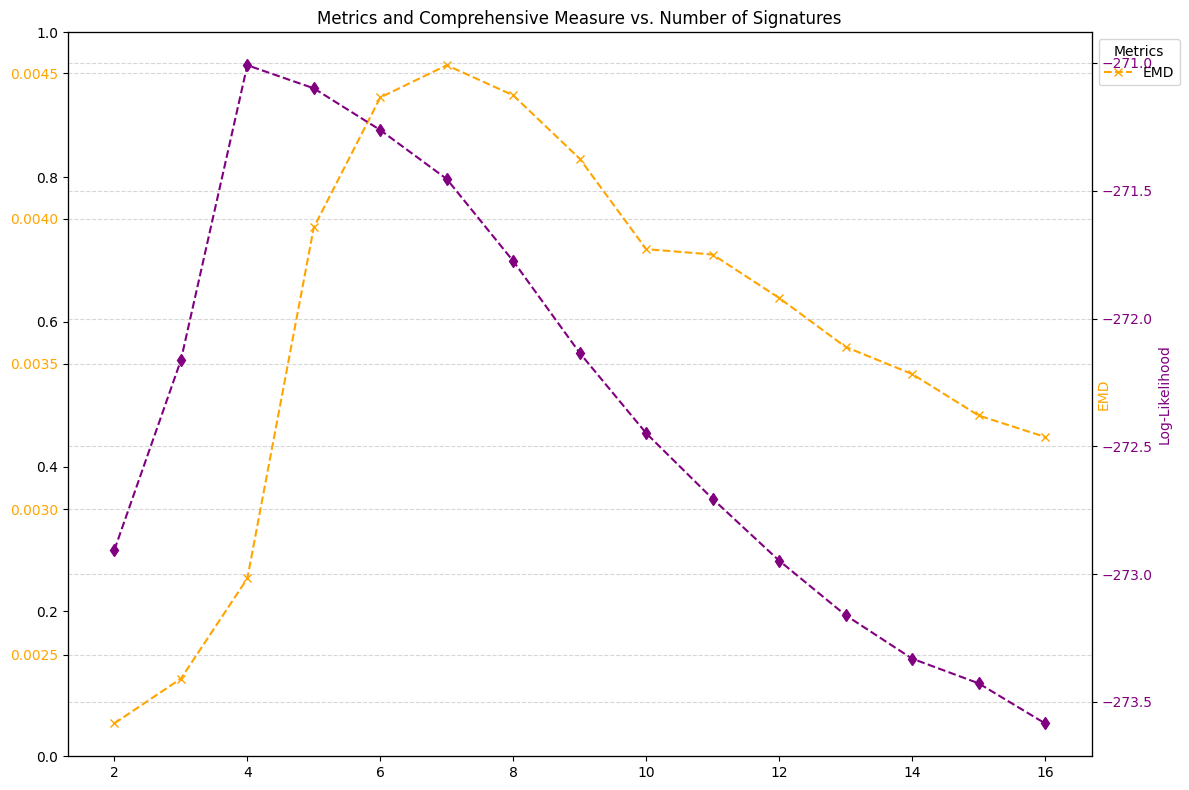

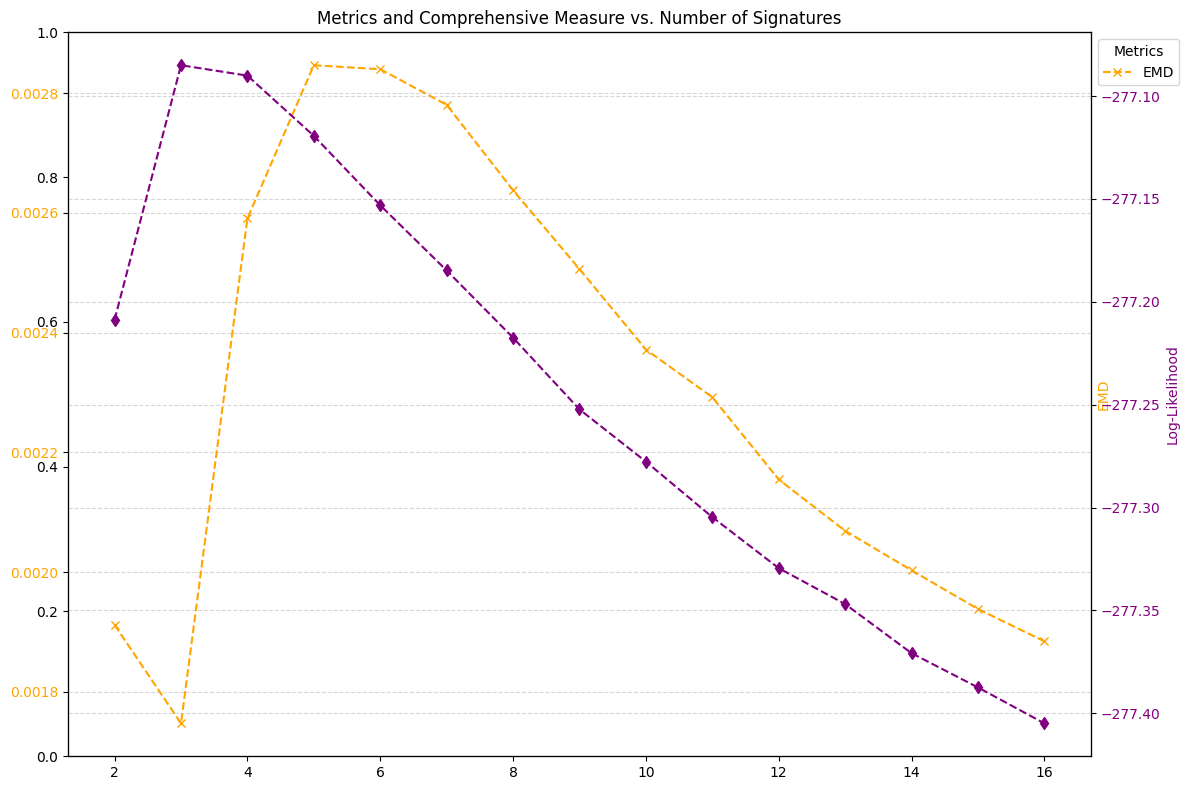

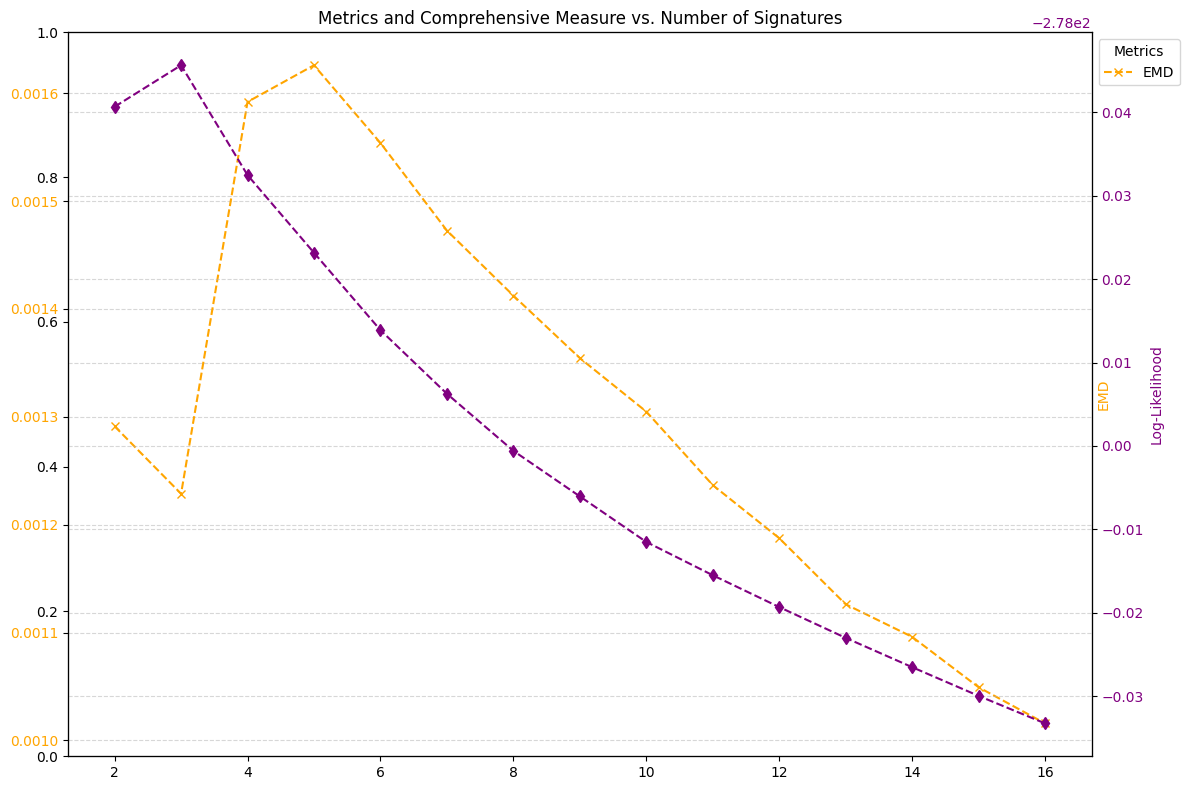

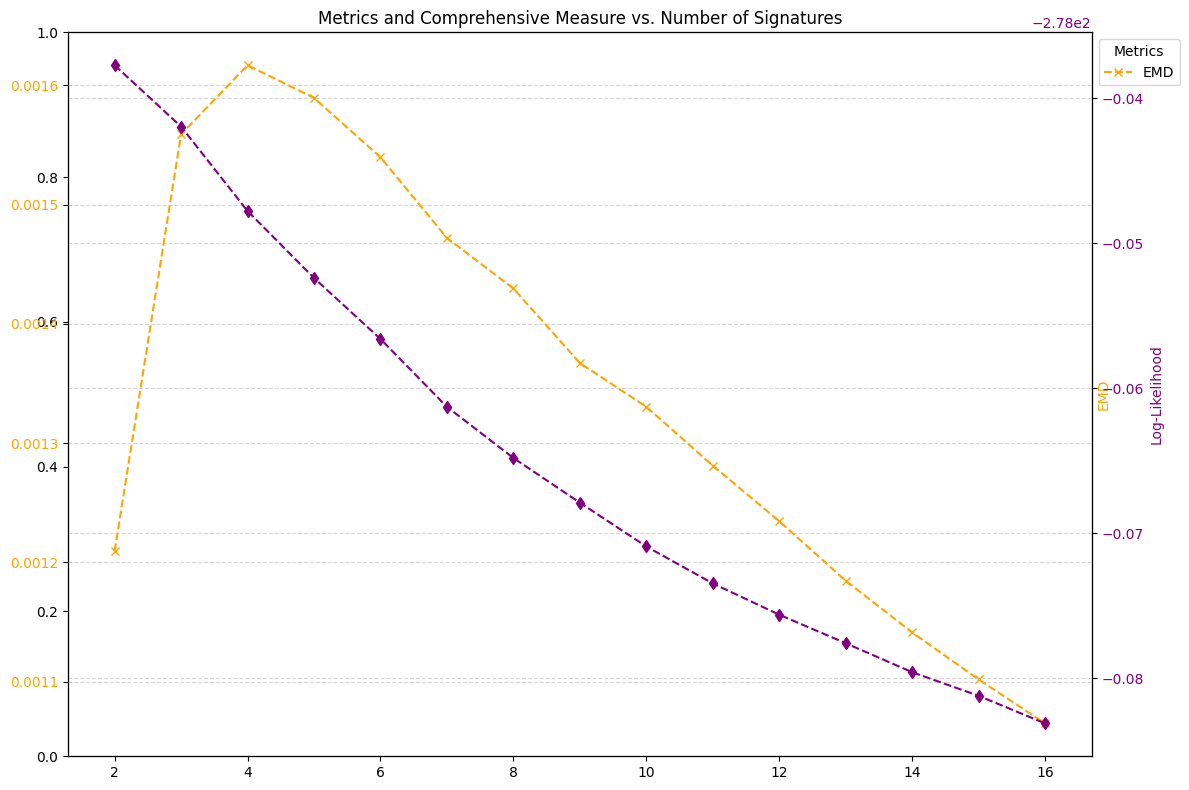

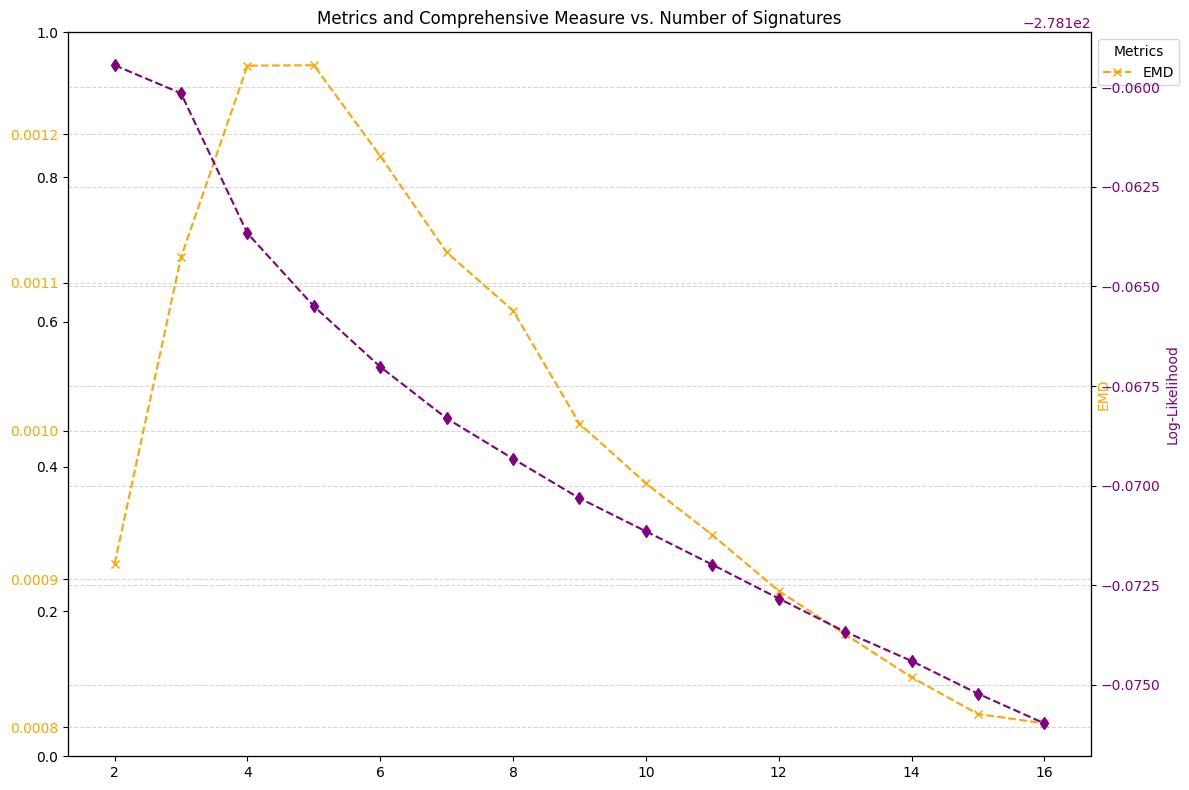

In [8]:
# Run the analysis
for i in range(1, 6):
    M_path = f'simulated_data/experiment_noise_1/data_v{i}_GRCh37_4_6_7a_9_18.csv'
    decomposed_matrices_folder = f'outputs/signature_matrices_passing_v{i}_exp2'
    perform_matrix_analysis_combined_plot(M_path, decomposed_matrices_folder, iterations=300, k_values=range(2, 17), verbose=False)